In [56]:
! pip install evaluate
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["WANDB_DISABLED"] = "true"

import torch
from datasets import load_dataset
import transformers
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TrainingArguments, 
                          Trainer,
                          DataCollatorWithPadding)
import evaluate
import numpy as np
from typing import Dict, Any
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("iitolstykh/LLMTrace_classification", split=['validation', 'test'])
ds[0] = ds[0].class_encode_column('label')
ds[1] = ds[1].class_encode_column('label')
    
print(ds[0]['label'])

In [ ]:
# чекпоинт модели
checkpoint = "/kaggle/input/distilbert-classifier-checkpoints/output/distilbert/distilbert-base-multilingual-cased_llm_trace_classification/checkpoint-6430"
# токенизатор для модели
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
def tokenize_example(example: Dict[str, Any]) -> Dict[str, Any]:
    """
    Функция токенизации
    --------------------------
    Parameters:
    example : datasets.DatasetDict
        датасет из библиотеки HF Datasets

     Returns:
    --------
    datasets.DatasetDict
        Токенизированный датасет
    """
    return tokenizer(
        example['text'],
        truncation = True,
        max_length = 256,
    )

In [ ]:
tokenized_validation = ds[0].map(tokenize_example, 
                      batched=True,
                      remove_columns = 
                      [name for name in ds[0].column_names if name != 'label'],
                     )
tokenized_test = ds[1].map(tokenize_example, 
                      batched=True,
                      remove_columns = 
                      [name for name in ds[1].column_names if name != 'label'],
                     )

In [ ]:
tokenized_validation[0]

In [ ]:
accuracy = evaluate.load('accuracy')
precision = evaluate.load('precision')
recall = evaluate.load('recall')
f1 = evaluate.load('f1')
metrics_func = [accuracy, precision, recall, f1]
def compute_metrics(eval_pred):
    """
    Вычисляет метрики по предсказанию модели и меткам
    """
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    result = dict()
    for func in metrics_func:
        if func is accuracy:
            result.update(func.compute(predictions=preds, references=labels))
        else:   
            result.update(func.compute(predictions=preds, references=labels, pos_label=0))
    return result

In [ ]:
tokenized_validation.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
print(tokenized_validation[0]['input_ids'].device)

In [85]:
from torch.utils.data import DataLoader

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
dataloader_valid = DataLoader(dataset=tokenized_validation, 
                              batch_size=512, 
                              shuffle=True, 
                              collate_fn=data_collator,
                              # num_workers = 4,
                             )

dataloader_test = DataLoader(dataset=tokenized_test, 
                              batch_size=512, 
                              shuffle=True, 
                              collate_fn=data_collator,
                              # num_workers = 4,
                             )
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, device_map='cuda')

In [ ]:
# collator = DataCollatorWithPadding(tokenizer=tokenizer)
# test_features = [{"input_ids": [1, 2, 3], "label": 1}, {"input_ids": [1, 2], "label": 0}]
# batch = collator(test_features)

# print(batch['input_ids'].device)

In [ ]:
# for _ in range(6)

In [78]:
from torch.nn.functional import softmax
from tqdm.auto import tqdm

all_probs = []
all_labels = []
model.eval()
for batch in tqdm(dataloader_valid, desc='Inference'):
    inputs = {k: v.to('cuda') for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits
        probs = softmax(input=logits, dim=-1)
        probs_ai_class = probs[:, 0]
        all_probs.extend(probs_ai_class.cpu().numpy())
        all_labels.extend(batch['labels'].numpy())
        # break

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# print(all_labels)
# print(all_probs)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Inference:   0%|          | 0/170 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [79]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

fpr, tpr, thresholds = roc_curve(all_labels, all_probs, pos_label=0)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Оптимальный порог для класса 0: {optimal_threshold:.4f}")

ROC-AUC: 0.9836
Оптимальный порог для класса 0: 0.8777


Оптимальный порог для класса 0 (F1-score): 0.7937
Precision при F1-пороге: 0.9603
Recall при F1-пороге: 0.9388
F1-Score при F1-пороге: 0.9494


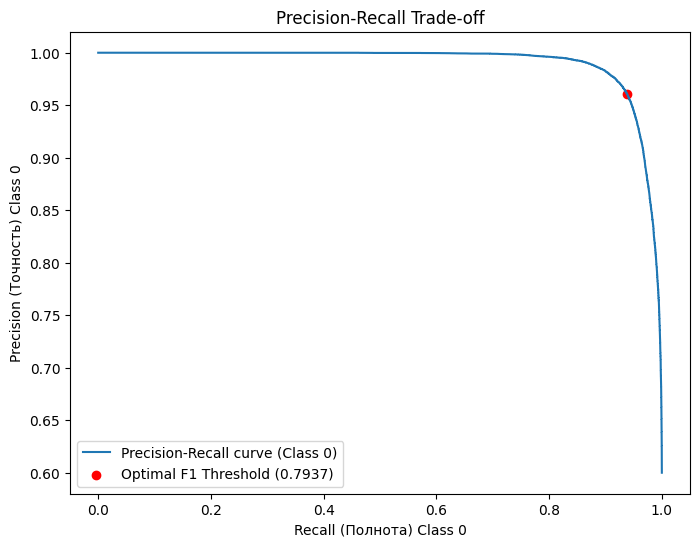

In [80]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Расчет кривой точность-полнота для класса 0
precision, recall, thresholds = precision_recall_curve(all_labels, all_probs, pos_label=0)

# Расчет F1-меры для каждого порога
fscore = 2 * (precision * recall) / (precision + recall)
fscore[np.isnan(fscore)] = 0 

# Поиск порога с максимальной F1-мерой
optimal_idx = np.argmax(fscore)
optimal_threshold_f1 = thresholds[optimal_idx]

print(f"Оптимальный порог для класса 0 (F1-score): {optimal_threshold_f1:.4f}")
print(f"Precision при F1-пороге: {precision[optimal_idx]:.4f}")
print(f"Recall при F1-пороге: {recall[optimal_idx]:.4f}")
print(f"F1-Score при F1-пороге: {fscore[optimal_idx]:.4f}")

# Визуализация PR-кривой и выбранной точки
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve (Class 0)')
plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', label=f'Optimal F1 Threshold ({optimal_threshold_f1:.4f})')
plt.xlabel('Recall (Полнота) Class 0')
plt.ylabel('Precision (Точность) Class 0')
plt.title('Precision-Recall Trade-off')
plt.legend()
plt.show()

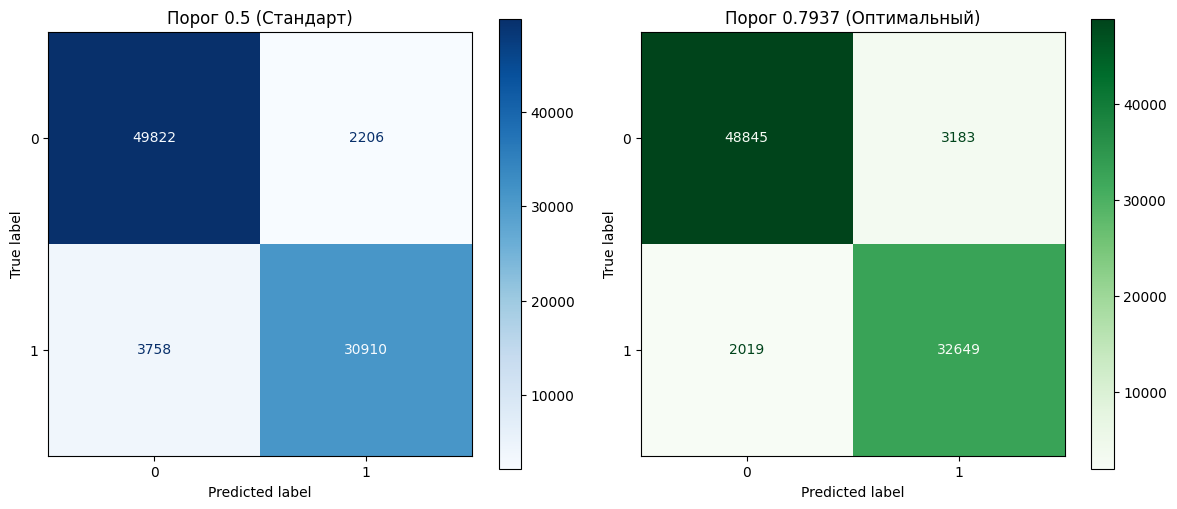

In [83]:
# Предсказания по порогу 0.5 (стандарт)
preds_standard = [0 if p >= 0.5 else 1 for p in all_probs]
# Предсказания по новому порогу
preds_optimal = [0 if p >= optimal_threshold_f1 else 1 for p in all_probs]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(all_labels, preds_standard, ax=ax[0], cmap='Blues', values_format='d')
ax[0].set_title(f"Порог 0.5 (Стандарт)")
ConfusionMatrixDisplay.from_predictions(all_labels, preds_optimal, ax=ax[1], cmap='Greens', values_format='d')
ax[1].set_title(f"Порог {optimal_threshold_f1:.4f} (Оптимальный)")

plt.tight_layout()
plt.show()

In [86]:
all_probs = []
all_labels = []
model.eval()
for batch in tqdm(dataloader_test, desc='TEST'):
    inputs = {k: v.to('cuda') for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits
        probs = softmax(input=logits, dim=-1)
        probs_ai_class = probs[:, 0]
        all_probs.extend(probs_ai_class.cpu().numpy())
        all_labels.extend(batch['labels'].numpy())
        # break

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# print(all_labels)
# print(all_probs)

TEST:   0%|          | 0/178 [00:00<?, ?it/s]

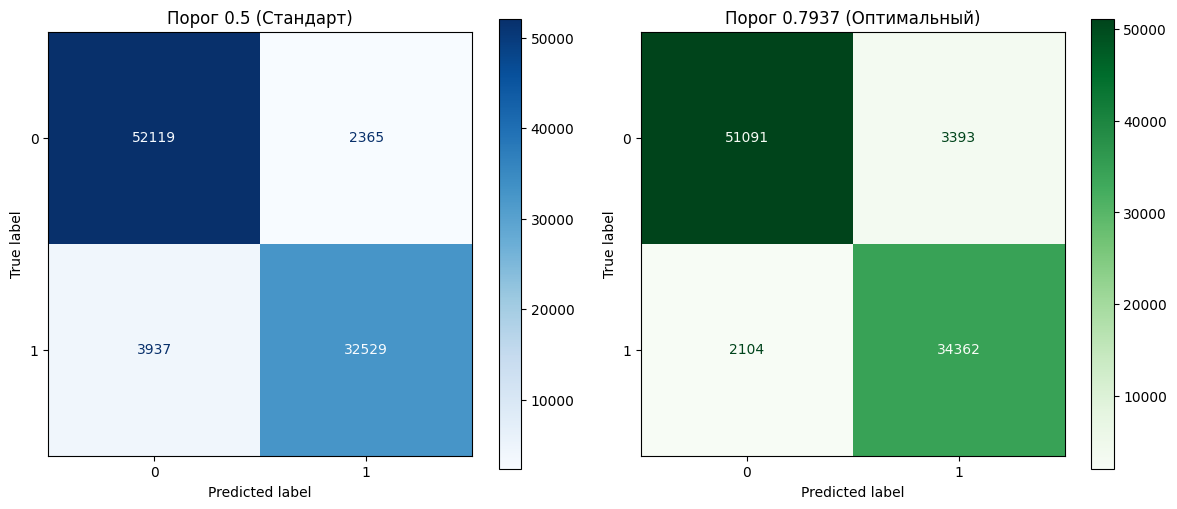

In [87]:
# Предсказания по порогу 0.5 (стандарт)
preds_standard = [0 if p >= 0.5 else 1 for p in all_probs]
# Предсказания по новому порогу
preds_optimal = [0 if p >= optimal_threshold_f1 else 1 for p in all_probs]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(all_labels, preds_standard, ax=ax[0], cmap='Blues', values_format='d')
ax[0].set_title(f"Порог 0.5 (Стандарт)")
ConfusionMatrixDisplay.from_predictions(all_labels, preds_optimal, ax=ax[1], cmap='Greens', values_format='d')
ax[1].set_title(f"Порог {optimal_threshold_f1:.4f} (Оптимальный)")

plt.tight_layout()
plt.show()

In [89]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f"accuracy:{accuracy_score(all_labels, preds_optimal)}")
print(f"precision:{precision_score(all_labels, preds_optimal, pos_label=0)}")
print(f"recall:{recall_score(all_labels, preds_optimal, pos_label=0)}")
print(f"f1:{f1_score(all_labels, preds_optimal, pos_label=0)}")

accuracy:0.93956019791094
precision:0.9604474104709089
recall:0.9377248366492915
f1:0.9489501202648613
